# Capsule Network

# 0. Setup

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

np.random.seed(42)
tf.random.set_seed(42)

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=4096)])
  except RuntimeError as e:
    print(e)

# 1. Parameter

In [3]:
eps         = 1e-7
m_plus      = .9
m_minus     = .1
lamda       = .5
alpha       = .0005
epochs      = 50
batch_size  = 100
lr          = 0.001
lr_decay_arg= 0.9
optimizer   = tf.keras.optimizers.Adam(lr=lr)

params = {
    'n_conv_filters'        : 256,
    'n_caps_primary'        : 32,
    'n_caps_digit'          : 10,
    'n_caps_primary_dim'    : 8,
    'n_caps_digit_dim'      : 16,
    'r'                     : 3,
}

# 2. Load MNIST

In [4]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = tf.expand_dims(tf.cast(x_train, dtype=tf.float32), axis=-1) / 255.0
x_test = tf.expand_dims(tf.cast(x_test, dtype=tf.float32), axis=-1) / 255.0

x_val, y_val = x_train[-10000:], y_train[-10000:]
x_train, y_train = x_train[:-10000], y_train[:-10000]

y_train = tf.one_hot(y_train, depth=10)
y_val = tf.one_hot(y_val, depth=10)

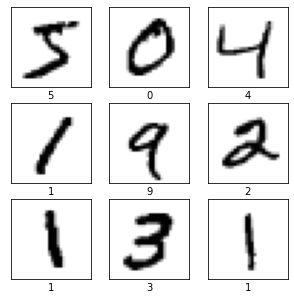

(50000, 28, 28, 1) (50000, 10)


In [5]:
plt.figure(figsize=(5, 5))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i], cmap=plt.cm.binary)
    plt.xlabel(np.argmax(y_train[i]))
plt.show()
print(x_train.shape, y_train.shape)

# 3. Capsule Network
```
                            Loss
                              ↑
                    ┌─────────┴─────────┐
      Labels → Margin Loss      Reconstruction Loss
                    ↑                   ↑
                  Length             Decoder
                    ↑                   ↑ 
             Digit Capsules ────Mask────┘
               ↖↑↗ ↖↑↗ ↖↑↗
             Primary Capsules
                    ↑      
               Input Images
```

## 3.0. Squash Function
>
$\operatorname{squash}(\mathbf{s}) = \dfrac{\|\mathbf{s}\|^2}{1 + \|\mathbf{s}\|^2} \dfrac{\mathbf{s}}{\|\mathbf{s}\|}$


In [6]:
def safe_norm(s, axis=-1, eps=1e-7):
    '''
    Calculation of norm as tf.norm(), but here we add a small value of eps 
    to the result to avoid 0
    '''
    s_ = tf.reduce_sum(tf.square(s), axis=axis, keepdims=True)
    return tf.sqrt(s_ + eps)

def squash(s):
    with tf.name_scope('SquashFunction') as scope:
        s_norm          = safe_norm(s, axis=-1, eps=eps)
        s_norm_squared  = tf.square(s_norm)
        return s_norm_squared / (1.0 + s_norm_squared) * s / s_norm

## 3.1. Primary Capsule

In [7]:
class PrimaryCaps(tf.keras.layers.Layer):
    '''
    This constructs a primary capsule layer using regular convolution layer
    '''
    def __init__(self, n_caps, n_dim, **kwargs):
        super().__init__(**kwargs)
        self.n_caps     = n_caps
        self.n_dim      = n_dim
        self.caps       = tf.keras.layers.Conv2D(
            filters     = self.n_caps * self.n_dim,
            kernel_size = 9, 
            strides     = 2, 
            name        = "PrimaryCapsule")
    
    @tf.function
    def call(self, x):                                                      # x.shape: (None, 20, 20, 256)
        x = self.caps(x)                                                    # x.shape: (None, 6, 6, 256)
        n_vect  = self.n_caps * x.shape[1] * x.shape[2]
        u       = tf.reshape(x, (-1, n_vect, self.n_dim))                   # u.shape: (None, 1152, 8)
        return u

## 3.2. Routing algorithm
>
$\hat{\mathbf{u}}_{j|i} = \mathbf{W}_{i,j} \, \mathbf{u}_i$
>
<b>procedure</b> ROUTING($\hat{\mathbf{u}}_{j|i}$, $r$, $l$)  
$\;\;\;\;$<b>for</b> all capsule $i$ in layer $l$ and capsule $j$ in layer $(l + 1)$:  
$\;\;\;\;\;\;\;\;b_{ij}←0$  
$\;\;\;\;$<b>for</b> $r$ iterations <b>do</b>  
$\;\;\;\;\;\;\;\;$for all capsule $i$ in layer $l$: $\mathbf{c}_i ← softmax(\mathbf{b}_i)$  
$\;\;\;\;\;\;\;\;$for all capsule $j$ in layer $(l + 1)$: $\mathbf{s}_j ← \sum_{i}c_{ij}\hat{\mathbf{u}}_{j|i}$  
$\;\;\;\;\;\;\;\;$for all capsule $j$ in layer $(l + 1)$: $\mathbf{v}_j ← squash(\mathbf{s}_j)$  
$\;\;\;\;\;\;\;\;$for all capsule $i$ in layer $l$ and capsule $j$ in layer $(l + 1)$: $b_{ij} ← b_{ij} + \hat{\mathbf{u}}_{j|i}.\mathbf{v}_j$  
$\;\;\;\;$<b>return</b> $\mathbf{v}_j$

In [8]:
class DigitCaps(tf.keras.layers.Layer):
    def __init__(self, n_caps, n_caps_dim, r=3, **kwargs):
        super().__init__(**kwargs)
        self.n_caps     = n_caps
        self.n_caps_dim = n_caps_dim
        self.r          = r

    def build(self, input_shape):
        self.W = self.add_weight(
            shape       = [1, input_shape[1], self.n_caps, self.n_caps_dim, input_shape[2]],
            initializer = tf.keras.initializers.GlorotUniform(),
            trainable   = True)
        self.built = True

    @tf.function
    def call(self, u):                                                      # u.shape: (None, 1152, 8)
        with tf.name_scope('CapsuleFormation') as scope:
            u       = tf.expand_dims(u, axis=-2)                            # u.shape: (None, 1152, 1, 8)
            u       = tf.expand_dims(u, axis=-1)                            # u.shape: (None, 1152, 1, 8, 1)
            u_hat   = self.W @ u                                            # u_hat.shape: (None, 1152, 10, 16, 1)
            u_hat   = tf.squeeze(u_hat, [4])                                # u_hat.shape: (None, 1152, 10, 16)

        with tf.name_scope('DynamicRouting') as scope:
            b       = tf.zeros((u.shape[0], u.shape[1], self.n_caps, 1))    # b.shape: (None, 1152, 10, 1)
            for _ in range(self.r):                                         # self.r = 3
                c         = tf.nn.softmax(b, axis=-2)                       # c.shape: (None, 1152, 10, 1)
                s         = tf.reduce_sum(c * u_hat, axis=1, keepdims=True) # s.shape: (None, 1, 10, 16)
                v         = squash(s)                                       # v.shape: (None, 1, 10, 16)
                agreement = tf.squeeze(tf.matmul(
                    tf.expand_dims(u_hat, axis=-1), 
                    tf.expand_dims(v, axis=-1), 
                    transpose_a=True), [4])                                 # agreement.shape: (None, 1152, 10, 1)
                b         += agreement
        return v

## 3.3. Model

In [9]:
class CapsuleNetwork(tf.keras.Model):
    def __init__(self, params, **kwargs):
        super().__init__(**kwargs)
        self.n_conv_filters     = params['n_conv_filters']
        self.n_caps_primary     = params['n_caps_primary']
        self.n_caps_primary_dim = params['n_caps_primary_dim']
        self.n_caps_digit       = params['n_caps_digit']
        self.n_caps_digit_dim   = params['n_caps_digit_dim']
        self.r                  = params['r']

        with tf.name_scope('Variables') as scope:
            # ReLU Conv1
            # Input: (None, 28, 28, 1)
            # Output: (None, 20, 20, 256)
            self.conv = tf.keras.layers.Conv2D(
                filters         = self.n_conv_filters,
                kernel_size     = 9,
                strides         = 1,
                name            = 'ConvolutionLayer',
                activation      = 'relu')

            # Primary Capsule
            # Input: (None, 20, 20, 256)
            # Output: (None, 1152, 8)
            self.caps_primary   = PrimaryCaps(
                self.n_caps_primary, 
                self.n_caps_primary_dim)

            # Digit Capsule
            # Input: (None, 1152, 8)
            # Output: (None, 1, 10, 16)
            self.caps_digit     = DigitCaps(
                self.n_caps_digit, 
                self.n_caps_digit_dim, self.r)

            self.decoder = tf.keras.Sequential(name ='Decoder')
            self.decoder.add(tf.keras.layers.Dense(512, activation='relu'))
            self.decoder.add(tf.keras.layers.Dense(1024, activation='relu'))
            self.decoder.add(tf.keras.layers.Dense(784, activation='sigmoid', dtype='float32'))

    def build(self, input_shape):
        pass

    def call(self, data):
        '''
            data_x.shape: (None, 28, 28, 1)
            data_y.shape: (None, 10)
        '''
        data_x, data_y = data

        x = self.conv(data_x)                                               # x.shape: (None, 20, 20, 256)
        u = self.caps_primary(x)                                            # u.shape: (None, 1152, 8)
        v = self.caps_digit(u)                                              # v.shape: (None, 1, 10, 16)
        v = tf.squeeze(v, [1])                                              # v.shape: (None, 10, 16)

        with tf.name_scope('Masking') as scope:
            y       = tf.expand_dims(data_y, axis=-1)                       # y.shape: (None, 10, 1)
            mask    = tf.cast(y, dtype=tf.float32)                          # mask.shape: (None, 10, 1)
            v_masked = mask * v                                             # v_mask.shape: (None, 10, 16)

        with tf.name_scope('Reconstruction') as scope:
            v_      = tf.reshape(v_masked, [-1, self.n_caps_digit * self.n_caps_digit_dim])   # v_.shape: (None, 160)
            reconstructed_image = self.decoder(v_)                          # reconstructed_image.shape: (None, 784)

        # Normalize output
        v = tf.reshape(safe_norm(v), [-1, self.n_caps_digit])               # v.shape: (None, 10)

        return v, reconstructed_image

    @tf.function
    def regenerate_image(self, x):
        with tf.name_scope('Reconstruction') as scope:
            v_                  = tf.reshape(x, [-1, self.n_caps_digit * self.n_caps_digit_dim]) # v_.shape: (None, 160)
            reconstructed_image = self.decoder(v_)                          # reconstructed_image.shape: (None, 784)

        return reconstructed_image

model = CapsuleNetwork(params)

## 3.4. Loss Function
### Margin Loss
>
$L_k = T_k max(0, m^+ - \|\mathbf{v}_k\|)^2 + \lambda(1 - T_k) max(0, \|\mathbf{v}_k\| - m^-)^2$

In [10]:
def margin_loss(y_true, y_pred):
    '''
        y_true.shape: (None, 10, 1)
        y_pred.shape: (None, 10)
    '''
    margin_left     = tf.square(tf.maximum(0.0, m_plus - y_pred))               # margin_left.shape: (None, 10)
    margin_right    = tf.square(tf.maximum(0.0, y_pred - m_minus))              # margin_right.shape: (None, 10)

    margin_left     = y_true * margin_left
    margin_right    = lamda * (1.0 - y_true) * margin_right
    L = margin_left + margin_right                                              # L.shape: (None, 10)
    L = tf.reduce_mean(tf.reduce_sum(L, axis=-1))                               # L.shape: () ~ scalar

    return L

### Mean Square Error

In [11]:
def mse_loss(y_true, y_pred):
    '''
        y_true.shape: (None, 28, 28, 1)
        y_pred.shape: (None, 784)
    '''
    y_true = tf.reshape(y_true, (-1, 784))

    L = tf.reduce_mean(tf.square(y_true - y_pred))

    return L

## 3.4. Training Model

In [12]:
# Create checkpoint object
log_dir = './logs/param'
log = tf.keras.callbacks.CSVLogger(
    log_dir + '/log.csv')

checkpoint_dir = './logs/model'
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_dir + '/weights-{epoch:02d}.h5',
    monitor             = 'val_output_1_accuracy',
    save_best_only      = True,
    save_weights_only   = True,
    verbose             = 1)

lr_decay = tf.keras.callbacks.LearningRateScheduler(
    schedule            = lambda epoch: lr * (lr_decay_arg ** epoch))

In [13]:
def train(model):
    model.compile(
        optimizer       = tf.keras.optimizers.Adam(lr=lr),
        loss            = [margin_loss, mse_loss],
        loss_weights    = [1.0, alpha],
        metrics         = {'output_1': 'accuracy'})

    history = model.fit(
        [x_train, y_train], [y_train, x_train],
        batch_size      = batch_size,
        epochs          = epochs,
        validation_data = ([x_val, y_val], [y_val, x_val]),
        callbacks       = [log, checkpoint, lr_decay])

In [14]:
train(model)

Epoch 1/50
500/500 [==============================] - 920s 2s/step - loss: 0.2006 - output_1_loss: 0.2005 - output_2_loss: 0.1888 - output_1_accuracy: 0.7847 - val_loss: 0.0198 - val_output_1_loss: 0.0197 - val_output_2_loss: 0.0659 - val_output_1_accuracy: 0.9845

Epoch 00001: val_output_1_accuracy improved from -inf to 0.98450, saving model to ./logs/model\weights-01.h5
Epoch 2/50
500/500 [==============================] - 819s 2s/step - loss: 0.0174 - output_1_loss: 0.0173 - output_2_loss: 0.0661 - output_1_accuracy: 0.9862 - val_loss: 0.0134 - val_output_1_loss: 0.0133 - val_output_2_loss: 0.0631 - val_output_1_accuracy: 0.9874

Epoch 00002: val_output_1_accuracy improved from 0.98450 to 0.98740, saving model to ./logs/model\weights-02.h5
Epoch 3/50
500/500 [==============================] - 979s 2s/step - loss: 0.0128 - output_1_loss: 0.0127 - output_2_loss: 0.0626 - output_1_accuracy: 0.9899 - val_loss: 0.0140 - val_output_1_loss: 0.0140 - val_output_2_loss: 0.0575 - val_output_1

KeyboardInterrupt: 

## 3.5. Feature Visualization

In [57]:
index = 11
value = 6

print(predict(model, tf.expand_dims(x_test[index], axis=0)), y_test[index])

[6] 6


(1, 1, 10, 16)


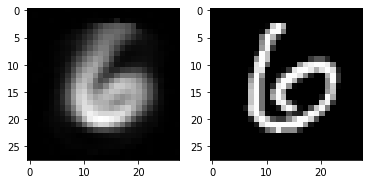

In [58]:
features = model.predict_capsule_output(tf.expand_dims(x_test[index], axis=0))
print(features.shape)

features_np = features.numpy()
# We don't need this because in features, out of 10 vectors, only the
# the one corresponding to the correct digit has high agreement with
# lower capsules, thus making it to have a significant length compared
# to the others
# temp = features_np.copy()
# features_np[:,:,:,:] = 0
# features_np[:,:,index,:] = temp[:,:,index,:]

reconstructed_image = model.regenerate_image(features_np)
reconstructed_image = tf.reshape(reconstructed_image, (28, 28))

plt.subplot(1, 2, 1)
plt.imshow(reconstructed_image, cmap='gray')
plt.subplot(1, 2, 2)
plt.imshow(x_test[index,:,:,0], cmap='gray')

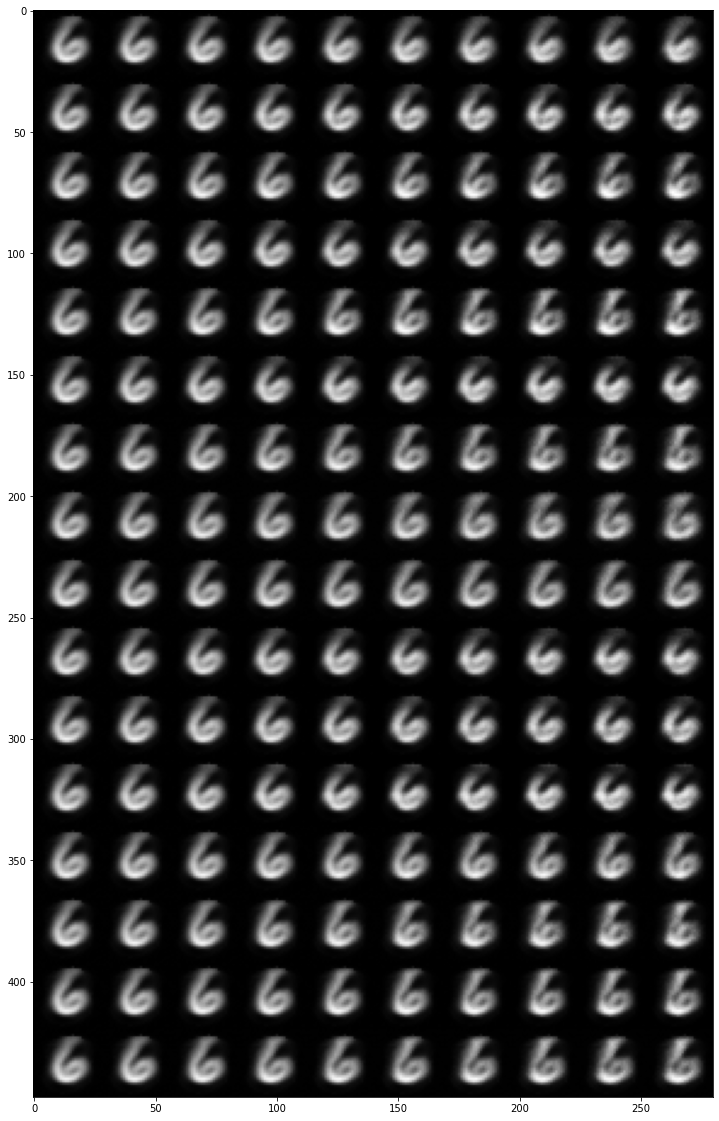

In [60]:
col = np.zeros((28, 308))
for i in range(16): 
    feature_ = features_np.copy()
    feature_[:,:,value, i] += -.1
    row = np.zeros((28,28))
    for _ in range(10):
        feature_[:,:,value, i] += 0.2
        row = np.hstack([row, tf.reshape(model.regenerate_image(tf.convert_to_tensor(feature_)), (28,28)).numpy()])
    col = np.vstack([col, row])

plt.figure(figsize=(30,20))
plt.imshow(col[28:, 28:], cmap='gray')